## Setup & Imports

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
import cv2

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/data"
train_dir = os.path.join(base_dir, "train")
aug_train_dir = os.path.join(base_dir, "train_aug")

In [4]:
def mk_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

In [5]:
classes = sorted(os.listdir(train_dir))
mk_dir(aug_train_dir)
for cls in classes:
    os.makedirs(os.path.join(aug_train_dir, cls))

### Load Image Paths per Class

In [6]:
image_paths = {cls: [] for cls in classes}

for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.endswith(".jpg"):
            image_paths[cls].append(os.path.join(cls_dir, fname))

for cls in classes:
    print(f"{cls}: {len(image_paths[cls])} images")

akiec: 98 images
bcc: 114 images
bkl: 286 images
df: 25 images
mel: 150 images
nv: 2869 images
vasc: 41 images


## Offline Augmentation with Albumentations

In [7]:
target_count = 3500

In [8]:
zoom_only = A.Compose([
    A.Affine(
        scale=1.17,
        translate_percent=0,
        rotate=0,
        shear=0,
        fit_output=False,
        mode=cv2.BORDER_REFLECT_101,
        p=1.0
    ),
    A.Resize(299, 299)
])

<ipython-input-8-119243421>:2: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(


In [9]:
augment_pipeline = A.Compose([
    A.Affine(
        scale=1.17,
        translate_percent=0,
        rotate=0,
        shear=0,
        fit_output=False,
        border_mode=cv2.BORDER_REFLECT_101,
        p=1.0
    ),

    A.Rotate(limit=45, border_mode=cv2.BORDER_REFLECT_101, p=0.8),

    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.3),

    A.RandomBrightnessContrast(
        brightness_limit=(-0.1, 0.18),
        contrast_limit=0.25,
        p=0.7
    ),

    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=20,
        val_shift_limit=15,
        p=0.5
    ),

    A.OneOf([
        A.OpticalDistortion(distort_limit=0.05, border_mode=cv2.BORDER_REFLECT_101),
        A.GridDistortion(num_steps=5, distort_limit=0.1, border_mode=cv2.BORDER_REFLECT_101),
    ], p=0.3),

    A.OneOf([
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=1.0),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.7, 1.0), p=1.0),
        A.GaussNoise(std_range=(0.02, 0.06), mean_range=(0.0, 0.0), p=1.0),
        A.MotionBlur(blur_limit=(3, 5), p=1.0),
    ], p=0.4),

    A.Resize(299, 299)
])

In [10]:
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    cls_aug_dir = os.path.join(aug_train_dir, cls)
    mk_dir(cls_aug_dir)

    images = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith(".jpg")]
    current = len(images)

    print(f"\nClass: {cls}")
    print(f"-> Found {current} original images.")
    print(f"-> Applying 'zoom_only' and saving zoomed versions...")

    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        zoomed = zoom_only(image=img)["image"]

        save_name = f"zoom_{i}_{os.path.basename(img_path)}"
        save_path = os.path.join(cls_aug_dir, save_name)
        Image.fromarray(zoomed).save(save_path)

    print(f"-> Saved {current} zoomed images to {cls_aug_dir}")

    need = target_count - current

    if need > 0:
        print(f"-> Need {need} more images to reach {target_count}.")
        print(f"-> Applying 'augment_pipeline'...")

        for i in range(need):
            src_img_path = images[i % current]
            img = cv2.imread(src_img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            augmented = augment_pipeline(image=img)["image"]

            save_name = f"aug_{i}_{os.path.basename(src_img_path)}"
            save_path = os.path.join(cls_aug_dir, save_name)
            Image.fromarray(augmented).save(save_path)

        print(f"-> Augmented by {need} images using 'augment_pipeline'.")
        print(f"Total images now in {cls_aug_dir}: {target_count}")
    else:
        print(f"No extra augmentation needed. Already has {current} images.")


Class: akiec
-> Found 98 original images.
-> Applying 'zoom_only' and saving zoomed versions...
-> Saved 98 zoomed images to /content/drive/MyDrive/Skin-Cancer-Detection/data/train_aug/akiec
-> Need 3402 more images to reach 3500.
-> Applying 'augment_pipeline'...
-> Augmented by 3402 images using 'augment_pipeline'.
Total images now in /content/drive/MyDrive/Skin-Cancer-Detection/data/train_aug/akiec: 3500

Class: bcc
-> Found 114 original images.
-> Applying 'zoom_only' and saving zoomed versions...
-> Saved 114 zoomed images to /content/drive/MyDrive/Skin-Cancer-Detection/data/train_aug/bcc
-> Need 3386 more images to reach 3500.
-> Applying 'augment_pipeline'...
-> Augmented by 3386 images using 'augment_pipeline'.
Total images now in /content/drive/MyDrive/Skin-Cancer-Detection/data/train_aug/bcc: 3500

Class: bkl
-> Found 286 original images.
-> Applying 'zoom_only' and saving zoomed versions...
-> Saved 286 zoomed images to /content/drive/MyDrive/Skin-Cancer-Detection/data/trai

## Visualize Final Class Distribution

In [11]:
final_counts = {cls: len(os.listdir(os.path.join(aug_train_dir, cls))) for cls in classes}
final_df = pd.DataFrame(list(final_counts.items()), columns=["Class", "Count"])

final_df["hue"] = final_df["Class"]

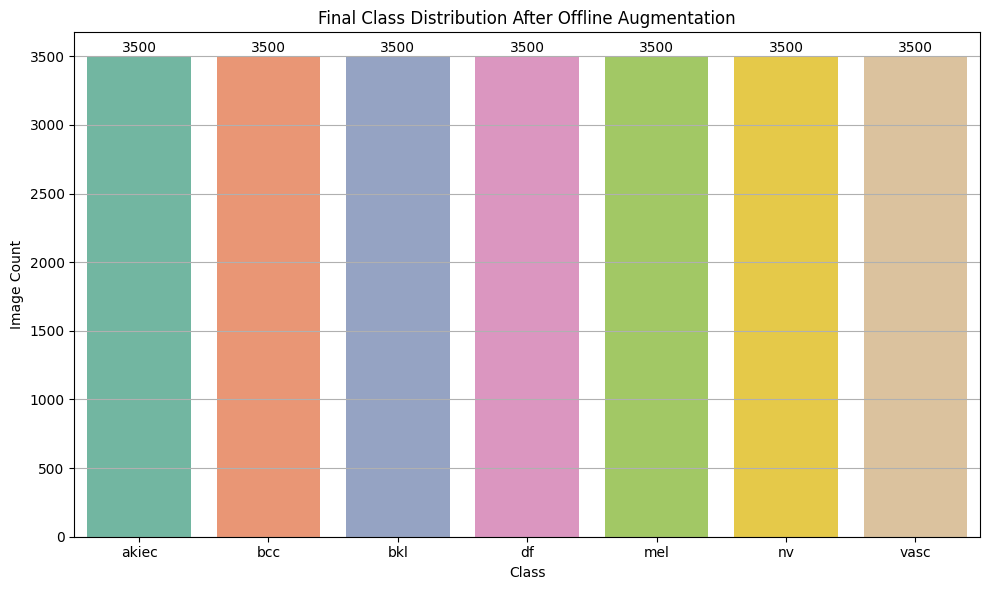

In [12]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=final_df, x='Class', y='Count', hue='hue', palette='Set2')
for i, row in final_df.iterrows():
    ax.text(i, row['Count'] + 10, str(row['Count']), ha='center', va='bottom', fontsize=10)

plt.title("Final Class Distribution After Offline Augmentation")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()